In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
def colab_download(proj_name,is_kaggle):
    import requests
    if is_kaggle:
        import sys
        sys.path.append("/kaggle/working/")

    project_name=proj_name

    url = f'http://kuroweb.tk:8000/api/v1/pack/wyftp/dataset/{project_name}.tar.gz'
    user, password = 'wuying', '123aaa'
    resp = requests.get(url, auth=(user, password))
    # write to file
    with open('download.tar.gz', 'wb') as f:
        f.write(resp.content)
    import tarfile

    # open file
    file = tarfile.open('download.tar.gz')
    # extracting file
    file.extractall('./')
    file.close()

    import shutil
    import os

    source_dir = f'./{project_name}'
    target_dir = './'

    file_names = os.listdir(source_dir)

    for file_name in file_names:
        try:
            shutil.move(os.path.join(source_dir, file_name), target_dir)
        except Exception as e:
            print(e,'at',file_name)



In [3]:
# colab_download('model',True)

In [4]:
# 上免那个不起作用

# !pip install -r requirements.txt

In [2]:
import json

import numpy as np

# record start time
import pandas as pd
import torch
from IPython.core.display import display
from keras import layers
# residual block
# https://stackoverflow.com/questions/64792460/how-to-code-a-residual-block-using-two-layers-of-a-basic-cnn-algorithm-built-wit
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from general_model.grow_numpy import GrowableNumpyArray
from general_model.list_batch_loader import ListBatchLoadDataset
from model_helper.single_gpu_dataloader import SingleGpuTensorWrapper
from pytorch_regression.regression_params import RegressionParams
from tool import ml, wine_tool, data_loader, wine_data_loader
from tool.dbg import dbg

In [3]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


No GPU found
Num GPUs Available:  0


D:\miniconda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
D:\miniconda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


酒精
{'name': '#1', 'degree': 70.5}
{'name': '#2', 'degree': 62.04}
{'name': '#3', 'degree': 55.84}
{'name': '#4', 'degree': 50.25}
{'name': '#5', 'degree': 45.23}
{'name': '#6', 'degree': 37.99}
{'name': '#7', 'degree': 30.39}
{'name': '#8', 'degree': 21.27}
{'name': '#9', 'degree': 12.76}
{'name': '#10', 'degree': 7.66}
{'name': '#11', 'degree': 1.53}
国之娇子
{'name': '#1', 'degree': 50.88}
{'name': '#2', 'degree': 47.83}
{'name': '#3', 'degree': 44.96}
{'name': '#4', 'degree': 41.36}
{'name': '#5', 'degree': 37.22}
{'name': '#6', 'degree': 33.5}
{'name': '#7', 'degree': 26.8}
{'name': '#8', 'degree': 19.3}
{'name': '#9', 'degree': 11.58}
{'name': '#10', 'degree': 6.95}
北京二锅头
威海卫烧锅
丁香情
原浆
北大仓
苦芥
五粮情
not exists: data4/#13
景芝白干
衡水老白干
老酒壶
牛栏山陈酿
杜二酒
小郎酒
闷倒驴
not exists: data4/#14
牛栏山二锅头
not exists: data4/#15


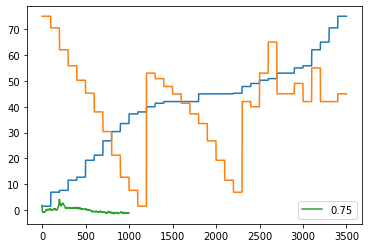

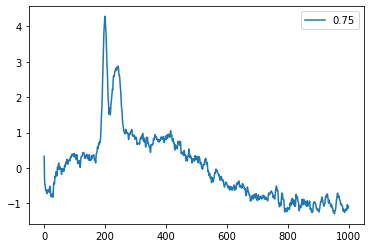

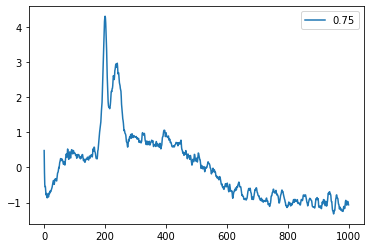

(2100, 1000) (2100,)


In [4]:
wine_json = ml.read_json("Wine.json")


class RegressionTrainer:
    def __init__(self):
        self.param = RegressionParams()
        self.param.batch_size = 64
        self.param.epoch = 1
        self.param.lr = 1e-9
        self.param.cnn_stride = 1
        self.param.cnn_size = 3
        self.param.pool_size = 2
        self.param.lr_decay = 0.99

    def load(self):

        self.x = GrowableNumpyArray(dtype=np.float, grow_speed=16)
        self.y = GrowableNumpyArray(dtype=np.float, grow_speed=16)

        for wine in wine_json:
            base_wine_path = 'data4/' + wine['id']
            dbg(wine['name'])
            if not os.path.exists(base_wine_path):
                dbg('not exists:', base_wine_path)
                continue
            # load data
            dirs = ml.getAllFiles(f'{base_wine_path}')
            for d in dirs:
                path = d
                files = ml.getAllFileRecursively(path)
                for f in files:
                    self.x.update(wine_tool.col2data_to_float_list(f))
                    self.y.add(wine['degree'])
                    # self.x = np.append(self.x, wine_tool.col2data_to_float_list(f))
                    # self.y = np.append(self.y, wine['degree'])

            # load item_data
            for wine_item in wine['items']:
                sub_wine_path = base_wine_path + '_' + wine_item['name']

                dirs = ml.getAllFiles(f'{sub_wine_path}')
                dbg(wine_item)
                for d in dirs:
                    path = d
                    files = ml.getAllFileRecursively(path)
                    for f in files[:100]:
                        self.x.update(wine_tool.col2data_to_float_list(f))
                        self.y.add(wine_item['degree'])
                        # self.x = np.append(self.x, wine_tool.col2data_to_float_list(f))
                        # self.y = np.append(self.y, wine_item['degree'])

        self.x = self.x.finalize()
        self.x = self.x.reshape((-1, 1000))

        self.y = self.y.finalize()

        plt.plot(sorted(self.y))
        plt.plot(self.y)

        # normalize

        self.y = self.y / 100

        layer_normed_x = torch.nn.LayerNorm([1000])(torch.tensor(self.x, dtype=torch.float))
        i = 0
        while i < 3:
            indice = i
            plt.plot(layer_normed_x[indice].detach().numpy(), label=self.y[indice])
            plt.legend()
            plt.show()
            i += 1

        self.x, self.y, self.x1, self.y1 = wine_data_loader.split(self.x, self.y, 1 - self.param.train_test_split)

        # wine_dataset = ListBatchLoadDataset(self.x.tensor, self.y.tensor)
        # self.dataloader = DataLoader(wine_dataset, batch_size=self.param.batch_size,
        #                         shuffle=True, num_workers=0)


trainer = RegressionTrainer()
trainer.load()
dbg(trainer.x.shape, trainer.y.shape)

In [5]:
tf.debugging.set_log_device_placement(False)

多层Dense模型

In [6]:

# act = 'tanh'
# # inp = __next = layers.Input(shape=[1280 * 720*10], name='input')
# inp = __next = layers.Input(shape=[1000], name='input')
# __next = layers.Dense(800, activation=act)(__next)
# __next = layers.Dense(800, activation=act)(__next)
# __next = layers.Dense(800, activation=act)(__next)
# __next = layers.Dense(104, activation=act)(__next)
# __next = layers.Dense(10, activation=act)(__next)
# output = __next = layers.Dense(1, )(__next)
# model = keras.Model(inputs=[inp], outputs=[output])
# model.summary()
# # opt = tf.keras.optimizers.Adam(lr=1e-4)
# opt = tf.keras.optimizers.Adam(lr=1e-6)
# model.compile(
#     optimizer=opt,
#     # optimizer='adam',
#     loss='mse',
# )

In [7]:
act = 'tanh'
config = [
    ('conv', 2, 3),
    ('pool', 2),
    ('activation',act),
    ('conv', 2, 3),
    ('pool', 2),
    ('activation',act),

    ('conv', 16, 3),
    ('pool', 2),
    ('activation',act),

    ("conv", 16, 3),
    ('pool', 2),
    ('activation',act),

    ("conv", 64, 3),
    ('pool', 2),
    ('activation',act),

    ("conv", 64, 3),
    ('pool', 2),
    ('activation',act),

]
# inp = __next = layers.Input(shape=[1280 * 720*10], name='input')
inp = __next = layers.Input(shape=[1000], name='input')
__next = layers.Reshape(target_shape=[1000, 1], name='reshape')(__next)

for c in config:
    if c[0] == 'conv':
        __next = layers.Conv1D(filters=c[1], kernel_size=c[2])(__next)
    elif c[0] == 'pool':
        __next = layers.MaxPool1D(pool_size=c[1])(__next)
    elif c[0] == 'activation':
        __next = layers.Activation(c[1])(__next)

__next = layers.Flatten()(__next)
output = __next = layers.Dense(1, )(__next)
model = keras.Model(inputs=[inp], outputs=[output])
model.summary()
# opt = tf.keras.optimizers.Adam(lr=1e-4)
opt = tf.keras.optimizers.Adam(lr=1e-6)
model.compile(
    optimizer=opt,
    # optimizer='adam',
    loss='mse',
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1000)]            0         
                                                                 
 reshape (Reshape)           (None, 1000, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, 998, 2)            8         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 499, 2)           0         
 )                                                               
                                                                 
 activation (Activation)     (None, 499, 2)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 497, 2)            14        
                                                             

D:\miniconda\envs\tf_gpu\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
history = model.fit(trainer.x, trainer.y,
                    # validation_data=(X_test, Y_test)
                    # epochs=50,
                    # epochs=100,
                    epochs=5,
                    # epochs=300,
                    )

Epoch 1/5
66/66 [==============================] - 1s 8ms/step - loss: 0.1899
Epoch 2/5
66/66 [==============================] - 1s 9ms/step - loss: 0.1616

In [12]:
history.history

{'loss': [0.1898978352546692,
  0.1616472601890564,
  0.1373050957918167,
  0.11654128134250641,
  0.0990111455321312]}

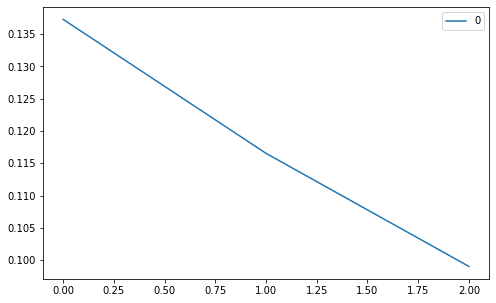

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
predict,0.158034,0.152612,0.152895,0.15293,0.182931,0.150951,0.15293,0.157165,0.152612,0.155647,0.156957,0.15293,0.171545,0.154219,0.15293
truth,0.076600,0.530000,0.558400,0.53000,0.212700,0.450000,0.50880,0.372200,0.450000,0.478300,0.750000,0.50880,0.420000,0.550000,0.53000
diff,0.081434,-0.377388,-0.405505,-0.37707,-0.029769,-0.299049,-0.35587,-0.215035,-0.297388,-0.322653,-0.593043,-0.35587,-0.248455,-0.395781,-0.37707


In [18]:
start_indice=(len(history.history["loss"])//2)
pd.DataFrame(history.history['loss'][start_indice:]).plot(figsize=(8, 5))
# plt.grid(True)
# plt.gca().set_ylim(0, 5e-4)
plt.show()


prediction = model.predict(trainer.x1)
dict = {'predict': prediction[:15, 0],
        'truth': trainer.y1[:15],
        'diff': (prediction[:15, 0] - trainer.y1[:15])
        }
df = pd.DataFrame(dict)

# displaying the DataFrame
display(df.T)


In [15]:
# 输出误差小于2.5度的百分比
dif = prediction.reshape(-1, ) - trainer.y1
np.sum((np.abs(dif) < 0.025)) / len(dif) * 100

73.0

NameError: name 'tf' is not defined